# Logistic Regression: Banking Marketing Campaign

This notebook analyzes a banking marketing campaign dataset to predict whether customers will subscribe to a term deposit. We'll build and optimize a logistic regression model to classify customer responses.

In [1]:
# Handle imports upfront
import pickle
import random
import warnings
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

## 1. Data acquisition

We'll start by loading the dataset from the provided URL and saving a local copy for future use.

### 1.1. Load the dataset

In [2]:
# Load the dataset from the provided URL
data_url = 'https://raw.githubusercontent.com/4GeeksAcademy/logistic-regression-project-tutorial/main/bank-marketing-campaign-data.csv'
data_df = pd.read_csv(data_url, sep=';')

In [3]:
data_df[['age', 'job', 'education', 'y']].head(5)

,age,job,education,y
0,56,housemaid,basic.4y,no
1,57,services,high.school,no
2,37,services,high.school,no
3,40,admin.,basic.6y,no
4,56,services,high.school,no


In [4]:
data_df['y'].head()

0    no
1    no
2    no
3    no
4    no
Name: y, dtype: object

### 1.2. Save local copy

In [5]:
# Make a directory for raw data
Path('../data/raw').mkdir(exist_ok=True, parents=True)

# Save a local copy of the raw data
data_df.to_parquet('../data/raw/bank-marketing-campaign-data.parquet')

### 1.3. Inspect

In [6]:
data_df.head().transpose()

,0,1,2,3,4
age,56,57,37,40,56
job,housemaid,services,services,admin.,services
marital,married,married,married,married,married
education,basic.4y,high.school,high.school,basic.6y,high.school
default,no,unknown,no,no,no
housing,no,no,yes,no,no
loan,no,no,no,no,yes
contact,telephone,telephone,telephone,telephone,telephone
month,may,may,may,may,may
day_of_week,mon,mon,mon,mon,mon


In [7]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

## 2. Data preparation

Before training our model, we need to prepare the data by splitting it into training and testing sets, and encoding categorical variables for use with scikit-learn.

### 2.1. Train-test split

In [8]:
# Split the data into training (75%) and testing (25%) sets
# This ensures we have unseen data to evaluate our final model
training_df, testing_df=train_test_split(
    data_df,
    test_size=0.25
)

### 2.2. Feature encoding

Machine learning algorithms work with numerical data, so we need to convert categorical variables (strings) to numerical format using ordinal encoding.

In [9]:
# Categorical features with 'object' datatypes (string) which need encoding
categorical_features = ['y','job','education','marital','default','housing','loan','contact','poutcome','day_of_week','month']

# Instantiate a encoder
encoder = OrdinalEncoder()

# Encode the categorical features in the training and testing datasets
training_df[categorical_features] = encoder.fit_transform(training_df[categorical_features])
testing_df[categorical_features] = encoder.transform(testing_df[categorical_features])

# Inspect the result - there should be only float or int datatypes left
training_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 30891 entries, 2159 to 736
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             30891 non-null  int64  
 1   job             30891 non-null  float64
 2   marital         30891 non-null  float64
 3   education       30891 non-null  float64
 4   default         30891 non-null  float64
 5   housing         30891 non-null  float64
 6   loan            30891 non-null  float64
 7   contact         30891 non-null  float64
 8   month           30891 non-null  float64
 9   day_of_week     30891 non-null  float64
 10  duration        30891 non-null  int64  
 11  campaign        30891 non-null  int64  
 12  pdays           30891 non-null  int64  
 13  previous        30891 non-null  int64  
 14  poutcome        30891 non-null  float64
 15  emp.var.rate    30891 non-null  float64
 16  cons.price.idx  30891 non-null  float64
 17  cons.conf.idx   30891 non-null  flo

## 3. Model training

We'll establish baseline performance using simple models, then build and optimize a logistic regression classifier.

In [10]:
# Empty dictionary to store results
results = {}

### 3.1. Random model performance

A random classifier serves as our weakest baseline - any useful model should significantly outperform random guessing.

In [11]:
# Generate random predictions for the testing set
# This serves as a baseline to compare our model performance against
predictions = [random.choice([0, 1]) for _ in range(len(testing_df))]

# Calculate accuracy of random model
accuracy = accuracy_score(testing_df['y'], predictions) * 100

# Store the accuracy in the results dictionary
results['Random'] = accuracy

print(f'Accuracy of random model: {accuracy:.2f}%')

Accuracy of random model: 50.07%


### 3.2. Constant 'no' model performance

Since this is a classification problem with imbalanced classes, we should check how well a model that always predicts the majority class would perform.

In [12]:
# Calculate accuracy if we always predict 'no' (the majority class)
accuracy = (testing_df['y'].value_counts()[0]/len(testing_df['y'])) * 100

# Store the accuracy in the results dictionary
results['Constant No'] = accuracy

print(f'Accuracy of constant "no" model: {accuracy:.2f}%')

Accuracy of constant "no" model: 88.23%


### 3.3. Logistic regression model performance

Now we'll train a basic logistic regression model with default parameters to see how much improvement we get over the baseline models.

In [13]:
# Train a basic logistic regression model with default parameters
model = LogisticRegression()
model.fit(training_df.drop('y', axis=1), training_df['y'])

# Make predictions on the testing set
predictions = model.predict(testing_df.drop('y', axis=1))

# Calculate accuracy of the test set predictions
accuracy = accuracy_score(testing_df['y'], predictions) * 100

# Store the accuracy in the results dictionary
results['Regression'] = accuracy

print(f"Testing accuracy: {accuracy:.2f}%")

Testing accuracy: 90.51%


### 3.4. Optimized logistic regression model performance

To get the best performance, we'll use grid search with cross-validation to find the optimal hyperparameters for our logistic regression model.

In [14]:
# Define hyperparameters to search over
# These parameters can significantly affect model performance
hyperparameters = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],  # Different optimization algorithms
    'fit_intercept': [True, False],  # Whether to include intercept term
    'max_iter': [50, 100, 200, 400, 800]  # Maximum iterations for convergence
}

# Use grid search with cross-validation to find best hyperparameters
# This systematically tests all combinations to find the optimal settings
model = LogisticRegression()
grid = GridSearchCV(model, hyperparameters, scoring='accuracy', cv=5)
grid.fit(training_df.drop('y', axis=1), training_df['y'])

# Save the best model and parameter combination
winning_parameters = grid.best_params_
winning_model = grid.best_estimator_

print(f'Best hyperparameters: {winning_parameters}')

Best hyperparameters: {'fit_intercept': True, 'max_iter': 50, 'solver': 'newton-cg'}


In [15]:
# Score the best model on the testing set
predictions = winning_model.predict(testing_df.drop('y', axis=1))
accuracy = accuracy_score(testing_df['y'], predictions) * 100

# Store the accuracy in the results dictionary
results['Optimized Regression'] = accuracy

print(f'Testing accuracy of optimized model: {accuracy:.2f}%')

Testing accuracy of optimized model: 90.68%


### 3.5. Results

Testing Accuracy Results:
----------------------------------------
Random                             : 50.07%
Constant No                        : 88.23%
Regression                         : 90.51%
Optimized Regression               : 90.68%


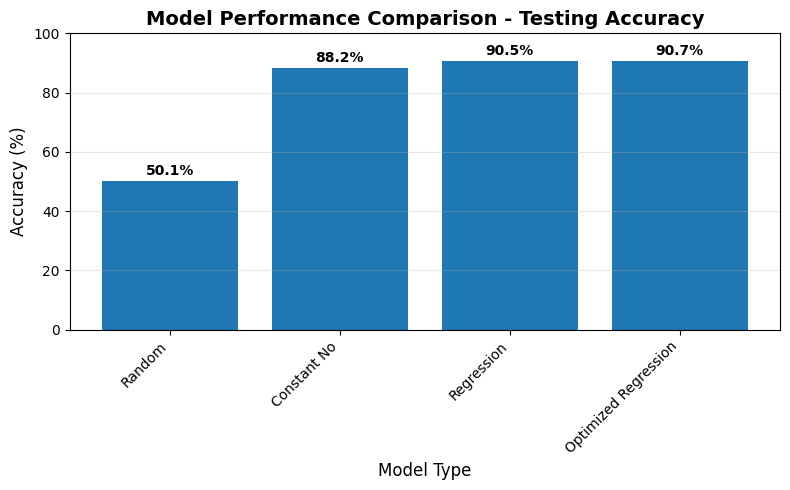

In [16]:
# Create a bar plot to compare model performance
plt.figure(figsize=(8, 5))
models = list(results.keys())
accuracies = list(results.values())

bars = plt.bar(models, accuracies)
plt.title('Model Performance Comparison - Testing Accuracy', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=12)
plt.xlabel('Model Type', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)

# Add value labels on top of bars
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{accuracy:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.grid(axis='y', alpha=0.3)

# Save the plot to assets directory
plt.savefig('../assets/model_performance_comparison.png', dpi=100, bbox_inches='tight')

# Print results summary
print("Testing Accuracy Results:")
print("-" * 40)

for model, accuracy in results.items():
    print(f"{model:35}: {accuracy:.2f}%")
    

## 4. Final model

With the best hyperparameters identified, we'll train our final model and evaluate its performance on the test set. The confusion matrix will help us understand how well the model performs for each class.

In [17]:
# Retrain model with winning hyperparameters on complete training set
final_model = LogisticRegression(**winning_parameters)
final_model.fit(training_df.drop('y', axis=1), training_df['y'])

# Calculate test set accuracy
predictions = final_model.predict(testing_df.drop('y', axis=1))
accuracy = accuracy_score(testing_df['y'], predictions) * 100
print(f'Final model test set accuracy: {accuracy:.2f}%')

Final model test set accuracy: 90.68%


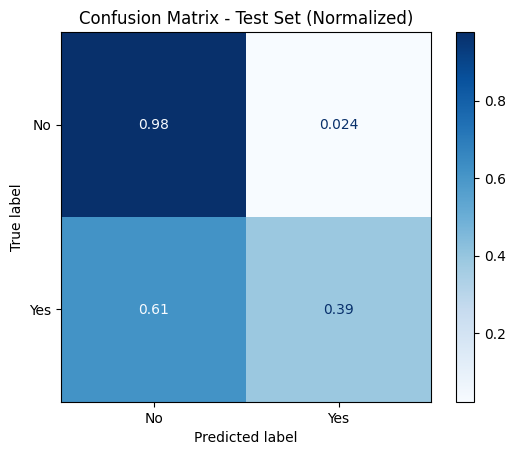

In [18]:
# Generate and display normalized confusion matrix
cm = confusion_matrix(testing_df['y'], predictions, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Test Set (Normalized)')

# Save the confusion matrix plot
plt.savefig('../assets/confusion_matrix_normalized.png', dpi=100, bbox_inches='tight')
plt.show()

In [19]:
# Make sure the models directory exists
Path('../models/model.pkl').parent.mkdir(exist_ok=True, parents=True)

# Save the final model
with open('../models/model.pkl', 'wb') as output_file:
    pickle.dump(winning_model, output_file)